# Conversion Rate

# Goal:
1. Build a model to predict conversion rate
2. Make recommendations to improve revenue (product team, marketing team)--increase conversion rate

# Step 1: Load, Investigate and Clean Data

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

In [2]:
df0 = pd.read_csv('conversion_data.csv')
df = df0.copy()

In [3]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
# cleaning age outliers
df = df[df['age']<80]

# Step2: Data Exploration and Analysis

In [7]:
print(df['converted'].value_counts(normalize=True))
print()
print(df['new_user'].value_counts(normalize=True))

0    0.967748
1    0.032252
Name: converted, dtype: float64

1    0.685469
0    0.314531
Name: new_user, dtype: float64


In [8]:
df.groupby('converted').agg(['mean'])

,age,new_user,total_pages_visited
,mean,mean,mean
converted,,,
0,30.703961,0.698382,4.550281
1,26.529025,0.298000,14.553932


In [9]:
country_conversion = df.groupby('country')['converted'].mean()
source_conversion = df.groupby('source')['converted'].mean()
new_user_conversion = df.groupby('new_user')['converted'].mean()
age_conversion = df.groupby('age')['converted'].mean()
page_conversion = df.groupby('total_pages_visited').converted.mean()

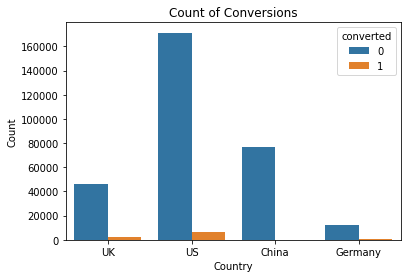

In [10]:
# 1 means converted
sns.countplot(df, x = 'country', hue = 'converted')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Conversions')
plt.show()

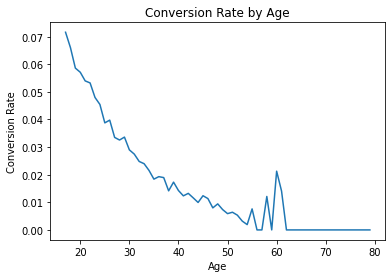

In [11]:
plt.plot(age_conversion)
plt.xlabel('Age')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Age')
plt.show()

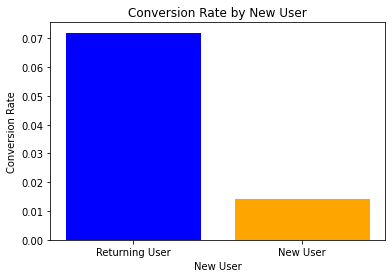

In [12]:
plt.bar(new_user_conversion.index, new_user_conversion, color=['blue', 'orange'])
plt.xlabel('New User')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by New User')
plt.xticks(new_user_conversion.index, ['Returning User', 'New User'])
plt.show()

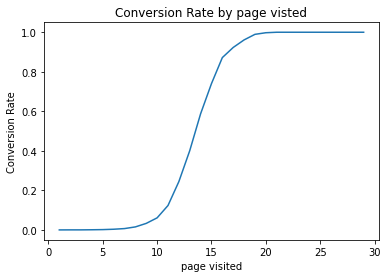

In [13]:
plt.plot(page_conversion)
plt.xlabel('page visited')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by page visted')
plt.show()

We only have a 4 % conversion rate and and we have 31% new user joining and 69% returning users
US has the highest amount of convserion rate follow by UK, Germany, then China
Younger audience tend to have higher conversion rate but there's a spike in conversion rate if the audience is near 60
returning users have a 5 times more likelihood of getting converted compare to new users
More page visted led to higher conversion rate and experiences a subtanail increase when page visted is above 10

# Summary EDA:

1. Our current conversion rate stands at 4%, with 31% of our user base being new joiners and the remaining 69% being returning users
2. US has the highest amount of conversion rate follow by UK, Germany, then China
3. Younger audiences generally exhibit higher conversion rates, but a notable spike is seen among users near the age of 60
4. Returning users have a 5 fold more likelihood of being converted compare to new users
5. There is a positive correlation between the number of page visits and conversion rates. Particularly, a substantial increase in conversion rates is observed when users exceed 10 page visits

# Suggestions:

- Target younger age groups
- Target high performing countries
- Improve conversion in low performing countries
- Focus more on returning users

# Model

## Loading Packages

In [14]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

## Data Preprecessing

In [15]:
df2 = pd.get_dummies(df, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316198 entries, 0 to 316199
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   age                  316198 non-null  int64
 1   new_user             316198 non-null  int64
 2   total_pages_visited  316198 non-null  int64
 3   converted            316198 non-null  int64
 4   country_Germany      316198 non-null  uint8
 5   country_UK           316198 non-null  uint8
 6   country_US           316198 non-null  uint8
 7   source_Direct        316198 non-null  uint8
 8   source_Seo           316198 non-null  uint8
dtypes: int64(4), uint8(5)
memory usage: 23.6 MB


In [16]:
# Isolate target variable (y)
y = df2['converted']

# Isolate the features (X)
X = df2.drop('converted', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Random Forest Classifier

In [17]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune 
cv_params = {'max_depth': [None, 3, 5],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [1, 2, 3],
             'n_estimators': [100, 200]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=3, refit='f1')

In [18]:
%%time
rf_cv.fit(X_train, y_train)

C:\Users\guoha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
54 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\guoha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\guoha\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "C:\Users\guoha\anaconda3\lib\site-packages\joblib\parallel.py", line 1863, in __call__
    return output if self.return_generator else list(output)
  File "C:\Users\guoha

Wall time: 12min 19s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 3, 5],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [100, 200]},
             refit='f1', scoring={'accuracy', 'recall', 'precision', 'f1'})

In [19]:
rf_cv.best_params_

{'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [20]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [21]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf_cv, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.835659,0.680313,0.749867,0.985365


In [22]:
# Get scores on test data
preds = rf_cv.best_estimator_.predict(X_test)

In [23]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [24]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.835659,0.680313,0.749867,0.985365
0,RF test,0.821958,0.678922,0.743624,0.984899


## XGBoost classifier

In [25]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {
    'min_child_weight': [1, 5],
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 500]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

In [26]:
%%time
xgb_cv.fit(X_train, y_train)

Wall time: 4min 26s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [33]:
xgb_cv.best_params_

{'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 500}

In [27]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB CV', xgb_cv, 'f1')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.835659,0.680313,0.749867,0.985365
0,RF test,0.821958,0.678922,0.743624,0.984899
0,XGB CV,0.851432,0.692080,0.763506,0.986172


In [28]:
# Get scores on test data
preds = xgb_cv.best_estimator_.predict(X_test)

In [29]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.835659,0.680313,0.749867,0.985365
0,RF test,0.821958,0.678922,0.743624,0.984899
0,XGB CV,0.851432,0.692080,0.763506,0.986172
0,XGB test,0.839190,0.690686,0.757731,0.985753


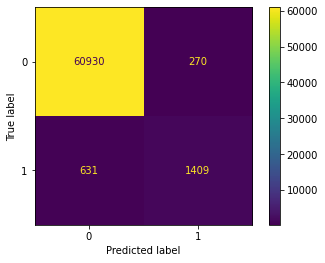

In [30]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb_cv.classes_)
disp.plot();

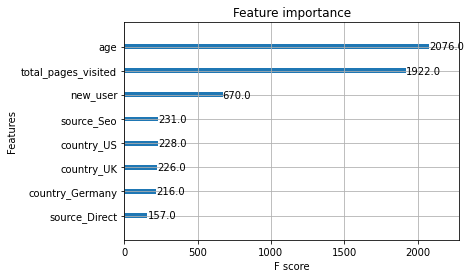

In [34]:
plot_importance(xgb_cv.best_estimator_);

# Summary

The analysis reveals that the XGBoost model outperforms others, with age, total pages visited, and new user status emerging as the most influential factors in predicting conversion. Given our business objective to prioritize precision and avoid expending resources ineffectively, achieving a precision score of 0.851432 is satisfactory for our initial model. However, it's noted that comparing these models against logistic regression could provide further insights into model performance.

Based on the findings, it's recommended to concentrate efforts on targeting young audiences, frequent visitors (more than 10 times), returning users, and users from the US, UK, and Germany, while deprioritizing users from China. This strategic focus aligns with maximizing conversion rates and optimizing resource allocation. Continued monitoring and refinement of models and strategies are advised to ensure ongoing effectiveness.